In [1]:
%matplotlib inline
import mxnet as mx
import logging
import numpy as np
import pandas as pd
from skimage import io, transform

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
# Load the pre-trained model
prefix = "model/Inception"
num_round = 9
model = mx.model.FeedForward.load(prefix, num_round, ctx=mx.cpu(), numpy_batch_size=1)

In [3]:
#load mean image
mean_img = mx.nd.load("Inception/mean_224.nd")["mean_img"]

In [20]:
mx.viz.plot_network(model.symbol, shape={"data" : (1, 3, 224, 224)})

In [21]:
# load synset (text label)
synset = [l.strip() for l in open('model/synset.txt').readlines()]

In [22]:
print mean_img.asnumpy().shape

(3, 224, 224)


In [23]:
mean_rgb = np.zeros((3, 224, 224))

In [24]:
mean_rgb = mean_rgb + 117

In [25]:
def PreprocessImage(path, show_img=False):
    # load image
    img = io.imread(path)
    #print("Original Image Shape: ", img.shape)
    if (len(img.shape) == 2):
        img = np.array([img,img,img])
        img = np.swapaxes(img, 0, 1)
        img = np.swapaxes(img, 1, 2)    
    # we crop image from center
    short_egde = min(img.shape[:2])
    yy = int((img.shape[0] - short_egde) / 2)
    xx = int((img.shape[1] - short_egde) / 2)
    crop_img = img[yy : yy + short_egde, xx : xx + short_egde]
    # resize to 224, 224
    resized_img = transform.resize(crop_img, (224, 224))
    if show_img:
        io.imshow(resized_img)
    # convert to numpy.ndarray
    sample = np.asarray(resized_img) * 256
    # swap axes to make image from (224, 224, 4) to (3, 224, 224)
    sample = np.swapaxes(sample, 0, 2)
    sample = np.swapaxes(sample, 1, 2)
    # sub mean 
    normed_img = sample - mean_rgb
    normed_img.resize(1, 3, 224, 224)
    return normed_img

def AnalyzeImage(path, show_img=False):
    # Get preprocessed batch (single image batch)
    batch = PreprocessImage(path, show_img)
    # Get prediction probability of 1000 classes from model
    prob = model.predict(batch)[0]
    # Argsort, get prediction index from largest prob to lowest
    pred = np.argsort(prob)[::-1]
    # Get top1 label
    top1 = synset[pred[0]]
    print("Top1: ", top1)
    # Get top5 label
    top5 = [synset[pred[i]] for i in range(5)]
    print("Top5: ", top5)

('Top1: ', "n03660124 Levi's, levis")
('Top5: ', ["n03660124 Levi's, levis", 'n03521899 Hip pocket', 'n03594734 Jean, blue jean, denim', 'n02847852 Blackwash', 'n03175189 Denim, dungaree, jean'])


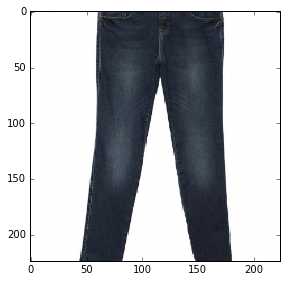

In [26]:
AnalyzeImage('/Users/Anna/Datasets/downloaded_images/lamoda/middle/jeans/AD006EWHPZ87_1_v2.jpg', True)

In [27]:
batch = PreprocessImage('/Users/Anna/Datasets/downloaded_images/lamoda/middle/jeans/AD006EWHPZ87_1_v2.jpg')

# get internals from model's symbol
internals = model.symbol.get_internals()
# get feature layer symbol out of internals
fea_symbol = internals["global_pool_output"]
# Make a new model by using an internal symbol. We can reuse all parameters from model we trained before
# In this case, we must set ```allow_extra_params``` to True
# Because we don't need params from FullyConnected symbol
feature_extractor = mx.model.FeedForward(ctx=mx.cpu(), symbol=fea_symbol, numpy_batch_size=1,
                                         arg_params=model.arg_params, aux_params=model.aux_params,
                                         allow_extra_params=True)
# predict feature
global_pooling_feature = feature_extractor.predict(batch)
print(global_pooling_feature.shape)
print(global_pooling_feature)

(1, 1024, 1, 1)
[[[[ 0.32965779]]

  [[ 0.05218945]]

  [[ 0.20945679]]

  ..., 
  [[ 0.98100483]]

  [[ 0.        ]]

  [[ 0.51361388]]]]


### Load

In [28]:
imagesinfo = pd.read_csv('csv/lamoda.csv')

In [31]:
imagesinfo.category.unique()

array(['Flats', 'Sandals', 'Ankle boots', 'Shoes', 'Jackboots',
       'Felt boots', 'Home shoes', 'Snowjoggers', 'Sneakers', 'Loafers',
       'New year shoes', 'Rain boot', 'Clogs', 'Boots', 'Slip-ons',
       'High Heels', 'Uggs', 'Slippers', 'Espadrilles', 'shirts',
       'jampers', 'sweatshirts', 'tops', 't-shirts', 'tunics', 'jeans',
       'skirts', 'pants', 'shorts'], dtype=object)

In [32]:
for i in range(0, len(imagesinfo)):
    imagesinfo.loc[i].file_name = path + imagesinfo.loc[i].type + '/' +imagesinfo.loc[i].category + '/' + imagesinfo.loc[i].file_name 

### Features

In [33]:
len(imagesinfo)

54073

In [34]:
len(feature_extractor.predict(batch).ravel())

1024

In [43]:
global_pooling_feature = pd.DataFrame(columns = np.arange(1024))
for i in range(0,len(imagesinfo)):
    batch = PreprocessImage(imagesinfo.file_name[i])
    print(global_pooling_feature.shape)
    global_pooling_feature.loc[i] = feature_extractor.predict(batch).ravel()

(0, 1024)
(1, 1024)
(2, 1024)
(3, 1024)
(4, 1024)
(5, 1024)
(6, 1024)
(7, 1024)
(8, 1024)
(9, 1024)
(10, 1024)
(11, 1024)
(12, 1024)
(13, 1024)
(14, 1024)
(15, 1024)
(16, 1024)
(17, 1024)
(18, 1024)
(19, 1024)
(20, 1024)
(21, 1024)
(22, 1024)
(23, 1024)
(24, 1024)
(25, 1024)
(26, 1024)
(27, 1024)
(28, 1024)
(29, 1024)
(30, 1024)
(31, 1024)
(32, 1024)
(33, 1024)
(34, 1024)
(35, 1024)
(36, 1024)
(37, 1024)
(38, 1024)
(39, 1024)
(40, 1024)
(41, 1024)
(42, 1024)
(43, 1024)
(44, 1024)
(45, 1024)
(46, 1024)
(47, 1024)
(48, 1024)
(49, 1024)
(50, 1024)
(51, 1024)
(52, 1024)
(53, 1024)
(54, 1024)
(55, 1024)
(56, 1024)
(57, 1024)
(58, 1024)
(59, 1024)
(60, 1024)
(61, 1024)
(62, 1024)
(63, 1024)
(64, 1024)
(65, 1024)
(66, 1024)
(67, 1024)
(68, 1024)
(69, 1024)
(70, 1024)
(71, 1024)
(72, 1024)
(73, 1024)
(74, 1024)
(75, 1024)
(76, 1024)
(77, 1024)
(78, 1024)
(79, 1024)
(80, 1024)
(81, 1024)
(82, 1024)
(83, 1024)
(84, 1024)
(85, 1024)
(86, 1024)
(87, 1024)
(88, 1024)
(89, 1024)
(90, 1024)
(91, 1024

In [50]:
global_pooling_feature.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,1.340799,0.158480,0.232880,0.081647,0.084810,0.034454,0.646507,0.058180,0.661784,0.360483,...,0.444015,0.231864,0.038863,0.574036,0.785982,1.726635,1.818732,0.0,0.939840,0.124891
1,1.972670,0.099346,0.018221,0.501671,0.450996,0.338363,1.303888,0.346789,0.352395,1.163371,...,0.000000,1.166205,1.277552,5.164815,0.413175,1.173229,0.375062,0.0,2.228860,0.386066
2,1.917654,0.115966,0.017972,0.499768,0.561262,0.394531,1.211926,0.188835,0.498704,1.262969,...,0.262652,1.902644,2.001256,4.123085,0.228662,1.831137,0.056129,0.0,3.309464,0.000000
3,2.458473,0.113120,0.018599,0.505867,0.249438,0.235639,1.675238,0.566560,0.203586,0.649089,...,0.637549,1.149248,2.246439,5.553423,0.098640,1.186700,0.343804,0.0,0.314858,0.076600
4,0.466291,0.193677,0.030709,0.246710,1.200571,0.104070,1.118056,0.091664,0.330545,0.982371,...,0.000000,0.550388,1.305317,2.247144,0.135947,2.077401,0.000000,0.0,1.887928,3.154037


In [58]:
result = imagesinfo.join(global_pooling_feature)

In [68]:
cols = result.columns

In [79]:
cols = cols.values

In [82]:
cols[0] = 'path_to_image'

In [84]:
result.columns = cols

In [86]:
lamoda = pd.read_csv('csv/lamoda.csv')

In [88]:
file_name = pd.DataFrame(data = lamoda.file_name, columns = ['file_name'])

In [89]:
res = file_name.join(result)

In [91]:
res.to_csv('csv/global_dataset.csv', index = False)